In [1]:
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy

In [2]:
import os
import time
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [3]:
start = time.time()

In [4]:
# define constants
ORIGINAL_PARENT_DIR = './FRUIT-16K' # enter path to original dataset
PREPROCESSED_PARENT_DIR = './FRUIT-16K-PREPROCESSED' # enter path to folder where you want the preprocessed data to go (code will create it)

CLASSES = []
for directory in os.listdir(ORIGINAL_PARENT_DIR):
    path = os.path.join(ORIGINAL_PARENT_DIR, directory)
    if os.path.isdir(path) and not directory.startswith('.'):
        CLASSES.append(directory)
print(CLASSES)

# define hyper-parameters
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
SEED = 10
TEST_SIZE = 0.2

['F_Banana', 'F_Strawberry', 'F_Tomato', 'F_Orange', 'F_Mango', 'F_Tamarillo', 'F_Lulo', 'S_Tamarillo', 'S_Lulo', 'S_Lemon', 'F_Lemon', 'S_Banana', 'S_Orange', 'S_Tomato', 'S_Strawberry', 'S_Mango']


In [5]:
def read_image(path):
    img = load_img(path, target_size = (IMAGE_HEIGHT, IMAGE_WIDTH))
    img_arr = img_to_array(img)
    return img_arr

def get_images_df(path):
    # walk through the path and create a dataframe
    # that has one column for the path to the image
    # and the other with the class name
    images_data = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if not file.startswith('.'):
                # add to dict [ image | class_name ]
                class_name = root.split(os.sep)[-1]
                image_path = os.path.join(root, file)
                images_data.append({
                    'image_path': image_path,
                    'class': class_name
                })
    df = pd.DataFrame(images_data)
    
    return df

def create_train_test_data(x_train, x_test, y_train, y_test, classes, save_path): 
    # create the train and test folders
    train_path = os.path.join(save_path, 'train')
    test_path = os.path.join(save_path, 'test')
    os.mkdir(train_path)
    os.mkdir(test_path)
        
    # for each class, make a subfolder
    for class_name in classes:
        os.mkdir(os.path.join(train_path, class_name))
        os.mkdir(os.path.join(test_path, class_name))
    
    # transfer files from dataframe image path to the appropriate
    # subfolder in save_path (sub folders based on class name)
    # also create x_train_final and x_test_final which will
    # store pixels of image
    x_train_final = []
    x_test_final = []
    for x_val, y_val in zip(x_train, y_train):
        new_path = os.path.join(train_path, y_val)
        shutil.copy(x_val, new_path)
        filename = x_val.split(os.sep)[-1]
        img_arr = read_image(os.path.join(new_path, filename))
        x_train_final.append(img_arr)
    for x_val, y_val in zip(x_test, y_test):
        new_path = os.path.join(test_path, y_val)
        shutil.copy(x_val, new_path)
        filename = x_val.split(os.sep)[-1]
        img_arr = read_image(os.path.join(new_path, filename))
        x_test_final.append(img_arr)
    
    return np.asarray(x_train_final), np.asarray(x_test_final), y_train, y_test
        
def transfer_data(original_dir, new_dir, classes, test_size):
    # get the images as a dataframe
    # this dataframe has two columns, one with
    # the path to the image in original_dir and one with
    # the class name
    original_df = get_images_df(original_dir)
    
    # split the df into train and test
    x, y = original_df['image_path'], original_df['class']
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 30, test_size = test_size)
    
    # create the new_dir folder
    if os.path.exists(new_dir):
        shutil.rmtree(new_dir)
    os.mkdir(new_dir)
    
    # transfer all the data from original_df to new_dir
    # with the appropriate formatting and get back the
    # split with the x arrays having the pixels associated
    # with the images and the y arrays having the label
    x_train, x_test, y_train, y_test = create_train_test_data(x_train, x_test, y_train, y_test, classes, save_path = new_dir)

    return x_train, x_test, y_train, y_test

In [6]:
x_train, x_test, y_train, y_test = transfer_data(ORIGINAL_PARENT_DIR, PREPROCESSED_PARENT_DIR, classes = CLASSES, test_size = TEST_SIZE)

In [7]:
# augment and preprocess the training data
train_image_data_generator = ImageDataGenerator(rescale = 1./255, zca_whitening=True, validation_split = 0.2)
print("done with train image generator")

# fit the train_image_data_generator to the train set
# only run this line of code if featurewise_center or featurewise_std_normalization or zca_whitening set to True
train_image_data_generator.fit(x_train)
print("done with fit")
    
train_generator = train_image_data_generator.flow(x_train, y_train, batch_size = BATCH_SIZE, seed = SEED, subset = 'training')

validation_generator = train_image_data_generator.flow(x_train, y_train, batch_size = BATCH_SIZE, seed = SEED, subset = 'validation')

# normalize the test data
# see https://stackoverflow.com/a/43069409
for i in range(len(x_test)):
    x_test[i] = train_image_data_generator.standardize(x_test[i])
print("done with flow")

/Users/taimurkashif/opt/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


done with train image generator
done with fit
done with flow


In [8]:
end = time.time()

In [9]:
print(end - start)

123.39646625518799


(32, 50, 50, 3)
S_Tamarillo


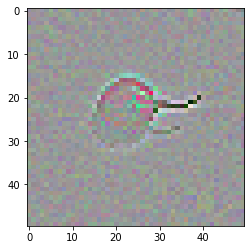

(32, 50, 50, 3)
S_Orange


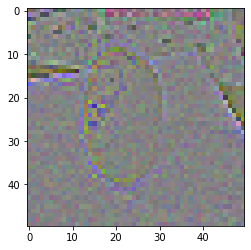

(32, 50, 50, 3)
F_Strawberry


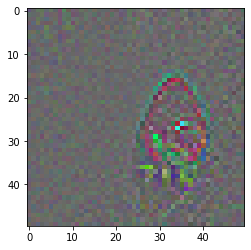

(32, 50, 50, 3)
S_Mango


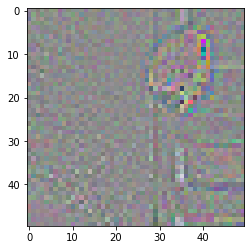

(32, 50, 50, 3)
S_Mango


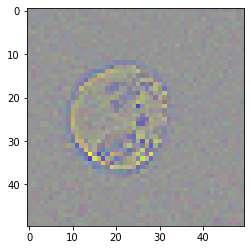

(32, 50, 50, 3)
S_Strawberry


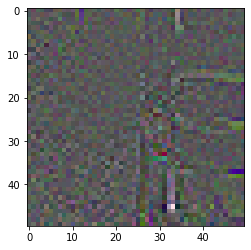

(32, 50, 50, 3)
S_Lemon


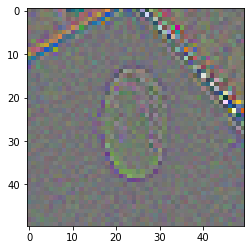

(32, 50, 50, 3)
F_Lemon


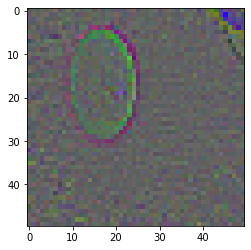

(32, 50, 50, 3)
F_Lulo


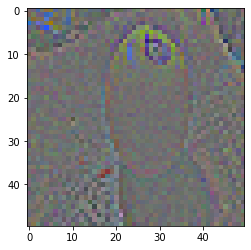

(32, 50, 50, 3)
S_Tomato


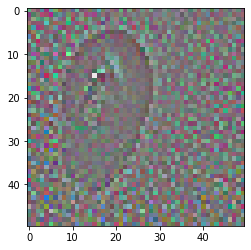

In [10]:
for _ in range(10):
    img, label = train_generator.next()
    print(img.shape)
    print(label[0])
    plt.imshow(array_to_img(img[0]))
    plt.show()

S_Banana


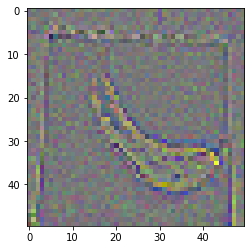

S_Orange


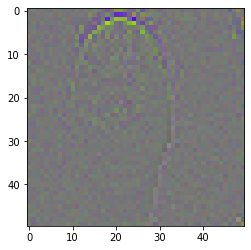

S_Lemon


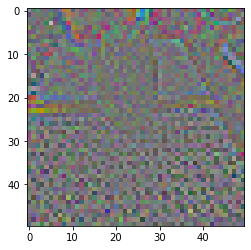

F_Lemon


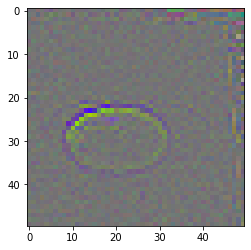

S_Mango


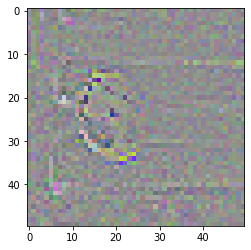

S_Lulo


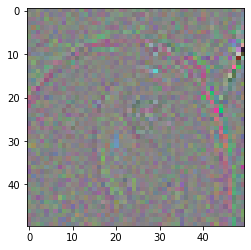

S_Tamarillo


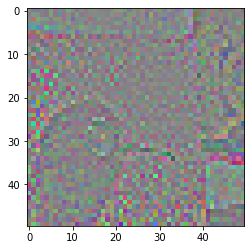

S_Banana


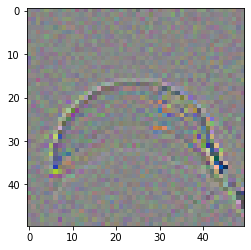

F_Banana


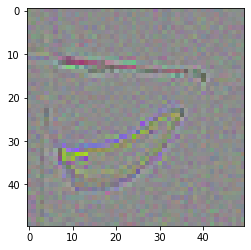

F_Lulo


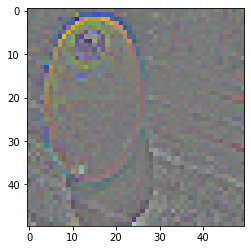

In [11]:
for i in range(10):
    print(list(y_test)[i])
    plt.imshow(array_to_img(x_test[i]))
    plt.show()